# Subsampling Techniques for Achieving Waveform Precision in Picoseconds

This notebook demonstrates how to realize timing precision at a fraction of a sample and it will cover:

- Fine shift with analytical function
- Subsampling shift with `sinc` kernel on individual waveforms
- Same as the previous bullet point, but on an output using the HDAWG real-time FIR filter


A more complete explanation of the techniques shown there can be found in [this blog post](https://www.zhinst.com/blogs/subsampling-techniques-achieving-waveform-precision-picoseconds).

This notebook implement this technique using zhinst-toolkit rather than LabOneQ.

Copyright (C) 2026 Zurich Instruments

This software may be modified and distributed under the terms of the MIT license. See the LICENSE file for details.

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import zhinst.toolkit as tk

## Analytical functions

Here we define a gaussian, whose center is shifted by a fraction of a sample:

In [2]:
def gaussian_subsample_shift(
    x, sigma=1 / 3, shift=0.4, length=..., sampling_rate=..., **_
):
    shift_sample = shift / sampling_rate / length * 2.0
    return np.exp(-((x - shift_sample) ** 2) / (2 * sigma**2))

when discretized, for different shifts, it will look like this:

![](step_animated_lin.svg)

We can recognize the Gaussian profile and how it is shifting with different positions, but the discrete sampling seems to distort our waveform. In reality, these discrete jumps will be filtered out by the antialiasing low-pass filter incorporated into the instrument. If we take that into account, the result is a smooth shift as we programmed:

![](filt_animated_lin.svg)

Now, let's plot the function we defined to verify that:

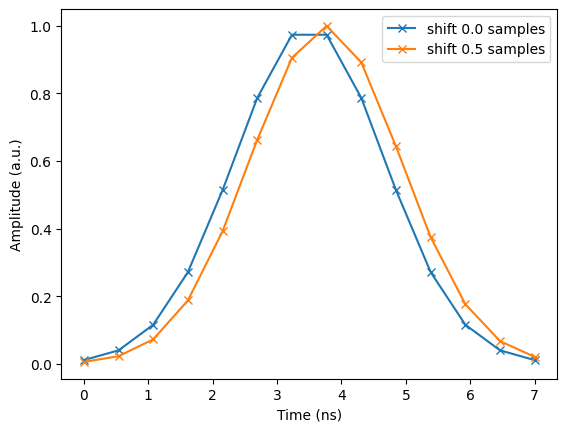

In [3]:
length = 7e-9  # s
shift = 0.5  # samples
sampling_rate = 2.0e9

plt.figure()

# Not shifted
x = np.linspace(-1.0, 1.0, int(length*sampling_rate))
time = np.linspace(0.0, length, int(length*sampling_rate))
wfm = gaussian_subsample_shift(x, length=length, shift=0.0, sampling_rate=sampling_rate)
plt.plot(time * 1e9, wfm, "x-", label="shift 0.0 samples")


# Shifted by half sample
wfm = gaussian_subsample_shift(x, length=length, shift=shift, sampling_rate=sampling_rate)
plt.plot(time * 1e9, wfm, "x-", label=f"shift {shift:.1f} samples")

plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (a.u.)")

plt.legend()

plt.show()

Finally, we can use it like any other pulse.

First, we connect to the data server, the device and set it up

In [ ]:
# Connect to the LabOne data server
session = tk.Session("localhost")
device = session.connect_device("DEVxxxx")

# Get awg and sigout objects
AWG_CORE = 2
SIGOUT = 4

awg = device.awgs[AWG_CORE]
sigout = device.sigouts[SIGOUT]

ct_schema = awg.commandtable.load_validation_schema()

# Various setup
device.system.clocks.sampleclock.freq(sampling_rate)

sigout.on(True)

We can then define a simple experiment where we played shifted version of such gaussian

In [5]:
seq = tk.Sequence()

seq.constants["REPETITIONS"] = 10
seq.constants["DELAY_STEPS"] = 11

seq.waveforms = tk.Waveforms()
seq.command_table = tk.CommandTable(ct_schema)
seq.command_table.active_validation = False

for i, delay in enumerate(np.linspace(0.0, 1.0, seq.constants["DELAY_STEPS"])):
    # Calculate the shifted waveform
    x = np.linspace(-1.0, 1.0, int(length*sampling_rate))
    wfm = gaussian_subsample_shift(x, length=length, shift=delay, sampling_rate=sampling_rate)

    # Pad it
    pad = max(2, int(np.ceil(len(wfm) / 16))) * 16 - len(wfm)
    wfm = np.concatenate((wfm, np.zeros(pad)))

    # Add to waveforms and command table
    seq.waveforms[i] = wfm
    seq.command_table.table[i].waveform.index = i

seq.code = """
var i;
repeat(REPETITIONS) {
    i = 0;
    do {
        executeTableEntry(i);
        setTrigger(1);
        playZero(0.5e-6*DEVICE_SAMPLE_RATE);
        setTrigger(0);
        i += 1;
    } while(DELAY_STEPS - i);
}"""

and runs it on real hardware

In [6]:
with device.set_transaction():
    awg.load_sequencer_program(seq)
    awg.write_to_waveform_memory(seq.waveforms)
    awg.commandtable.upload_to_device(seq.command_table)
    awg.enable(True)

## Non-analytical waveforms

Here we show how to shift sampled waveforms

In [7]:
# Generate a sampled waveform
# Here we use (again!) a gaussian, but anything will work

length = 7e-9  # s
sampling_rate = 2.0e9

x = np.linspace(-1.0, 1.0, int(length*sampling_rate))
wfm = gaussian_subsample_shift(x, length=length, shift=0.0, sampling_rate=sampling_rate)

For that we use a FIR `sinc` filter:

In [8]:
shift = 0.5  # samples

from scipy.signal import lfilter

from subsampling import fractional_delay_filter

# Length of the filter
# Must be odd, or 0.5 samples of shift should be accounted for
N = 41

# Calculate the FIR filter
fir, tau_g = fractional_delay_filter(
    mu=shift,
    fs_hz=2.0e9,  # must use 2.4e9 with a standalone HDAWG
    f_bw_hz=900e6,
    N=N,
)

# zero-pad the waveform. That assume the original waveform is zero at its extrema
wfm_padded = np.concatenate((np.zeros(N), wfm, np.zeros(N)))
# Use lfilter to filter the waveform with the FIR filter
wfm_shifted = lfilter(fir, 1.0, wfm_padded)
# Cut the now useless padding
# There is a N/2 group delay accounted for
wfm_shifted = wfm_shifted[3 * N // 2 : -N // 2]

Let's plot them!

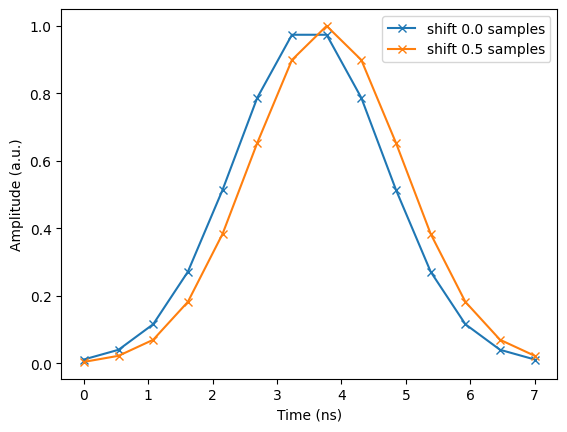

In [9]:
plt.figure()

# Not shifted
plt.plot(time * 1e9, wfm, "x-", label="shift 0.0 samples")

# Shifted by half sample
plt.plot(time * 1e9, wfm_shifted, "x-", label=f"shift {shift:.1f} samples")

plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (a.u.)")

plt.legend()

plt.show()

Such arrays of samples can be used as before

## Real-time HDAWG FIR filter

The HDAWG has a real-time FIR filter that we can use for this purpose (PC option needed).

Instead of shifting all the waveforms, we program it, and the entire output will be shifted. This is useful for deskewing signal lines.

The function `get_delay_settings` takes a delay as an input and calculates the FIR filter and the port_delay necessary to reach that delay

Let's define a single pulse experiment:

In [10]:
if not "PC" in device.features.options():
    raise RuntimeError("Precompensation option (PC) not installed!")

In [11]:
seq = tk.Sequence()

seq.waveforms = tk.Waveforms()
seq.command_table = tk.CommandTable(ct_schema)
seq.command_table.active_validation = False

# Calculate the shifted waveform
x = np.linspace(-1.0, 1.0, int(length*sampling_rate))
wfm = gaussian_subsample_shift(x, length=length, shift=0.0, sampling_rate=sampling_rate)

# Pad it
pad = max(2, int(np.ceil(len(wfm) / 16))) * 16 - len(wfm)
wfm = np.concatenate((wfm, np.zeros(pad)))

# Add to waveforms and command table
seq.waveforms[0] = wfm
seq.command_table.table[0].waveform.index = 0

seq.code = """
    executeTableEntry(0);
    setTrigger(1);
    playZero(0.5e-6*DEVICE_SAMPLE_RATE);
    setTrigger(0);
"""

and let's calculate and add the correct calibration to add the delay

In [12]:
from subsampling import get_delay_settings

node_delay, fir, _ = get_delay_settings(
    delay=1.95e-9, fs_hz=sampling_rate
) 

# Set the node delay
sigout.delay(node_delay)

# Enable and program the FIR filter
sigout.precompensation.enable(True)
sigout.precompensation.fir.enable(True)
sigout.precompensation.fir.coefficients(fir)

and runs it on real hardware

In [13]:
with device.set_transaction():
    awg.load_sequencer_program(seq)
    awg.write_to_waveform_memory(seq.waveforms)
    awg.commandtable.upload_to_device(seq.command_table)
    awg.enable(True)

The shift can be observed with a fast scope by triggering on the marker output.